# <center> SIFT detection 


***

# Import Data

In [308]:
ls

features.pck   images/        images_test/   myntradataset/ styles.csv


In [1]:
cd fashion-product-images-small/

/Users/fatmamoalla/Desktop/OMA/S2/VIC/project/fashion-product-images-small


In [2]:
import pandas as pd
styles = pd.read_csv('styles.csv',sep=',',error_bad_lines=False)
styles.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [3]:
dic_classes = list(set(styles['subCategory']))
dic_classes.sort()
dic ={ classe: idx for (idx, classe) in enumerate(dic_classes)}
print(dic)

{'Accessories': 0, 'Apparel Set': 1, 'Bags': 2, 'Bath and Body': 3, 'Beauty Accessories': 4, 'Belts': 5, 'Bottomwear': 6, 'Cufflinks': 7, 'Dress': 8, 'Eyes': 9, 'Eyewear': 10, 'Flip Flops': 11, 'Fragrance': 12, 'Free Gifts': 13, 'Gloves': 14, 'Hair': 15, 'Headwear': 16, 'Home Furnishing': 17, 'Innerwear': 18, 'Jewellery': 19, 'Lips': 20, 'Loungewear and Nightwear': 21, 'Makeup': 22, 'Mufflers': 23, 'Nails': 24, 'Perfumes': 25, 'Sandal': 26, 'Saree': 27, 'Scarves': 28, 'Shoe Accessories': 29, 'Shoes': 30, 'Skin': 31, 'Skin Care': 32, 'Socks': 33, 'Sports Accessories': 34, 'Sports Equipment': 35, 'Stoles': 36, 'Ties': 37, 'Topwear': 38, 'Umbrellas': 39, 'Vouchers': 40, 'Wallets': 41, 'Watches': 42, 'Water Bottle': 43, 'Wristbands': 44}


# Build helpers functions

In [4]:
from tqdm import tqdm
import cv2
import numpy as np
import scipy
#from scipy.misc import imread
import pickle
import random
import os
import matplotlib.pyplot as plt
import time
from lshash.lshash import LSHash
from PIL import Image

# Feature extractor
def extract_features(image_path, vector_size=159):
    image = cv2.imread(image_path)
    plt.imshow(image)
    sift = cv2.xfeatures2d.SIFT_create()
    # computing descriptors vector
    kps, dsc =sift.detectAndCompute(image,None)
    
    needed_size = (vector_size * 64)
    # Flatten all of them in one big vector - our feature vector
    if not(dsc is None):
        dsc = dsc.flatten()
    elif dsc is None:
        dsc = []
    if np.size(dsc) < needed_size:
    # if we have less the 32 descriptors then just adding zeros at the
    # end of our feature vector
        dsc = np.concatenate([dsc, np.zeros(needed_size - np.size(dsc))])
    
    return dsc

def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    result = {}
    max_features =0
    for f in tqdm(files):
        
        
        name = f.split('/')[-1].lower()
        if name !='.ds_store':

            result[name] = extract_features(f)
            
            if np.shape(result[name])[0] > max_features:
                max_features = np.shape(result[name])[0]
    print('max_features',max_features)
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

# Buil matcher class

In [5]:
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path,'rb') as fp:
            self.data = pickle.load(fp)
        self.hashtable = None
        self.kmeans = None
        
    def store_descriptors (self):
        ## Locality Sensitive Hashing
        # params
        k = 20 # hash size
        L = len(self.data.keys())  # number of tables , self.data.keys
        d = 159*64 # Dimension of Feature vector
        self.hashtable = LSHash(hash_size=k, input_dim=d, num_hashtables=L)
        # LSH on all the images
        for img_path, vec in tqdm(self.data.items()):
            self.hashtable.index(vec, extra_data=img_path)
            
  #  def cos_cdist(self, vector):
        # not used
        # getting cosine distance between search image and images database
   #     v = vector.reshape(1, -1)
    #    return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

        
    def match(self, image_path, topn=3):
        print('start match')
        start = time.time()
        self.store_descriptors()
        end = time.time()
        print('Hash table built in', end-start)
        
        start = time.time()
        dsc = extract_features(image_path)
        end = time.time()
        print('SIFT descriptor extract in',end -start )
        
        start = time.time()
        response = self.hashtable.query(dsc,num_results=topn, distance_func='hamming')
        end = time.time()
        print('Query done in', end -start)

        return response

In [7]:
def show_img(path):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = 'images_test'
    #images_path_test = 'images_test'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    #files_test = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 3 random images 
    topn= 5
    sample = random.sample(files, 1)
    start = time.time()
    print(" Sift vocab ext= ==========================================")
    batch_extractor(images_path)
    end = time.time()
    ma = Matcher('features.pck')
    print('features constructed in',end-start)
    
    
    for s in sample:
        print ('Query image ==========================================')
        start = time.time()
        show_img(s)
        indexes  = ma.match(s, topn)
        print(np.shape(indexes))
        end = time.time()
        print('Matched sample in',end-start) 
        print ('Result images ========================================')
        columns = 5
        rows = 1
        fig=plt.figure(figsize=(8, 8))
        print(indexes[0][0][1],indexes[1][0][1],indexes[2][0][1])
        for i in range( columns):  
            img = Image.open(images_path+'/'+indexes[i][0][1])
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(img)
        plt.show()
        

            

# Run the matcher on all the images

- It takes 7 min to build the histogram vocabulary for the whole dataset

  3%|▎         | 17/540 [00:00<00:03, 167.31it/s]

 Sift vocab ext= ==========================================


100%|██████████| 540/540 [00:03<00:00, 165.86it/s]


max_features 10176
features constructed in 3.381985902786255
Query image ==========================================


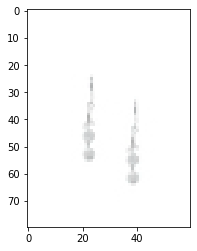

start match


100%|██████████| 539/539 [04:22<00:00,  2.34it/s]


Hash table built in 268.2343261241913
SIFT descriptor extract in 0.03019118309020996
Query done in 0.9379119873046875
(3, 2)
Matched sample in 271.5333969593048
Result images ========================================
59535.jpg 58965.jpg 59524.jpg


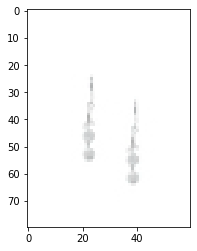

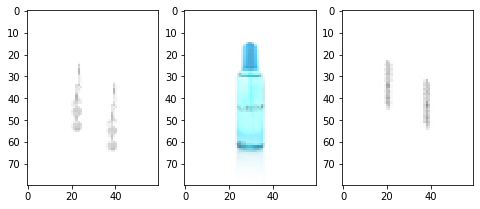

In [30]:
# First Example
run()

  3%|▎         | 15/540 [00:00<00:03, 148.58it/s]

 Sift vocab ext= ==========================================


100%|██████████| 540/540 [00:02<00:00, 182.95it/s]


max_features 10176
features constructed in 3.04880428314209
Query image ==========================================


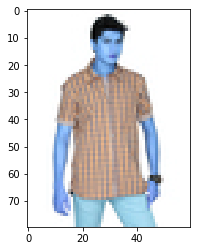

start match


100%|██████████| 539/539 [03:43<00:00,  2.36it/s]


Hash table built in 228.1950511932373
SIFT descriptor extract in 0.03335285186767578
Query done in 1.1287450790405273
(3, 2)
Matched sample in 232.08983993530273
Result images ========================================
8802.jpg 59833.jpg 59304.jpg


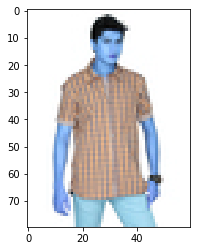

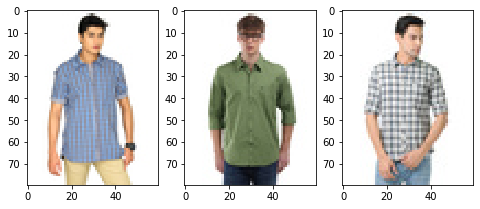

In [31]:
# Second Example
run()

  3%|▎         | 17/540 [00:00<00:03, 165.56it/s]

 Sift vocab ext= ==========================================


100%|██████████| 540/540 [00:02<00:00, 259.21it/s]


max_features 10176
features constructed in 2.1595458984375
Query image ==========================================


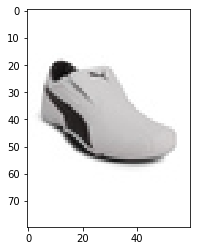

start match


100%|██████████| 539/539 [03:22<00:00,  3.00it/s]


Hash table built in 207.27903699874878
SIFT descriptor extract in 0.022205829620361328
Query done in 0.663834810256958
(5, 2)
Matched sample in 210.2257010936737
Result images ========================================
9124.jpg 8928.jpg 58533.jpg


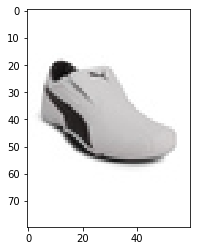

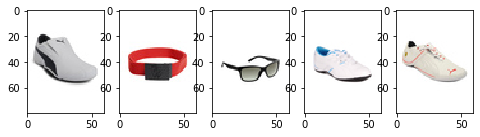

In [8]:
# Third example
run()